Elastic-net model did not work very well. Try non-linear models

# 0. Import modules

In [1]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
import logging
import matplotlib.pyplot as plt
import subprocess
from scipy import stats
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d'))

logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)

2024-01-31


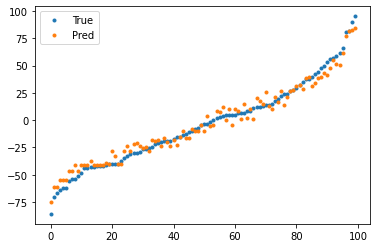

In [2]:
# Testing example
X, y = make_regression(n_features=4, n_informative=2,
                       random_state=0, shuffle=False)
regr = AdaBoostRegressor(random_state=0, n_estimators=50)
regr.fit(X, y)
regr.predict([[0, 0, 0, 0]])
regr.score(X, y)
fig, ax = plt.subplots()
df_data = pd.DataFrame({'y_true':y, 'y_pred':regr.predict(X)})
df_data.sort_values(by='y_true', inplace=True)
ax.plot(range(len(df_data)), df_data['y_true'], label='True', ls='', marker='.')
ax.plot(range(len(df_data)), df_data['y_pred'], label='Pred', ls='', marker='.')
ax.legend()

# 1. Pick a few lipid species to test based on heritability

In [10]:
# Load h2 data to selet lipid with highest h2
h2_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/prediction_models/elastic_net/merged_h2_r2'
fn = f'merged_h2_r2_{data_type}_{lipid_type}_{pval_threshold}_{maf_threshold}.txt'
print(fn)
df_h2 = pd.read_csv(os.path.join(h2_dir, fn), sep='\t').sort_values('h2', ascending=False)
display(df_h2.head(5))
display(df_h2.tail(5))


merged_h2_r2_train_species_pval_1e-07_maf_0.01.txt


,Lipid_name,h2,se,95CI,Lipid,pearson_r2,pearson_pval,model_fitting_r2
469,CE-20:4-,0.999999,0.185907,0.364378,CE(20:4),0.024245,3.575895e-10,-0.017679
468,CE-20:5-,0.999999,0.188218,0.368907,CE(20:5),0.019479,1.970866e-08,-0.007307
467,DE-20:4-,0.998330,0.191236,0.374823,DE(20:4),0.019253,2.383185e-08,-0.013485
466,PC-16:0_20:4-,0.976646,0.179809,0.352426,PC(16:0_20:4),0.044155,1.785337e-17,-0.029422
465,PC-18:0_20:4-,0.946600,0.180321,0.353429,PC(18:0_20:4),0.041298,2.017023e-16,-0.009982


,Lipid_name,h2,se,95CI,Lipid,pearson_r2,pearson_pval,model_fitting_r2
56,PG-34:1-,0.000001,0.179375,0.351575,PG(34:1),0.004812,0.005431,0.000651
57,PC-16:0_18:3-_-a-,0.000001,0.187640,0.367774,PC(16:0_18:3) (a),0.004396,0.007882,-0.014758
58,TG-54:0-_[SIM],0.000001,0.188249,0.368968,TG(54:0) [SIM],0.000073,0.731602,-0.019749
59,PC-16:0_20:3-_-b-,0.000001,0.176448,0.345838,PC(16:0_20:3) (b),0.003784,0.013710,-0.000812
0,LPE-16:0-_[sn1],0.000001,0.179871,0.352547,LPE(16:0) [sn1],0.004266,0.008863,-0.013856


## 1.1 Model training

In [77]:
# Load SNP dosage, use pval threshold 1e-05, maf 0.01
def load_dosage(snp_dir, snp_fn, lipid = 'CE-20:5-',
                dosage_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/genotype_dosage/train/lipid_species',
                dosage_fn = 'lipid_species_chr*.pval_0.001_maf_0.05.vcf.dosage.gz'):
    # logging.getLogger().setLevel(logging.WARNING)
    # logging.basicConfig(level=logging.WARNING)

    # threshold = f'{pval_threshold}_maf_0.01'
    # lipid = 'CE-20:5-'
    logging.info('# Load filtered SNPs')
    # snp_dir = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_{lipid_type}_filter_by_{threshold}'
    # snp_fn = f'{lipid}_SNPs.{pval_threshold}.{maf_threshold}.txt'
    # snp_fn = f'{lipid}_SNPs.{threshold}.txt'
    # print(os.path.join(snp_dir, snp_fn))
    df_snps = pd.read_csv(os.path.join(snp_dir, snp_fn), sep='\t')

    logging.info('# Get SNP dosage')
    for i in range(1,23):
        if not os.path.isfile(os.path.join(dosage_dir, dosage_fn.replace('*', str(i)))):
            logging.error('# Dosage file not found: %s' % dosage_fn)

    snps_all, dosage_all,lst_sample_ids = [], [], [] # SNPs and dosage found and used in model
    total_num_snps = len(df_snps)
    c = 0
    for chr_num, df in df_snps.groupby(by='CHR'):
        logging.info('# Get dosage from CHR%s'%chr_num)
        # Create a list of positions to search by tabix
        lst_pos = 'chr' + df['CHR'].astype('str') + ':' + df['POS'].astype('str') + '-' + df['POS'].astype('str')
        for pos in lst_pos:
            cmd = f'tabix {os.path.join(dosage_dir, dosage_fn.replace("*", str(chr_num)))} {pos} | cut -f 1-5,10-'
            dosage = subprocess.run(cmd, shell=True, text=True, capture_output=True).stdout
            if dosage != '' and len(dosage.split('\n'))==2: # Ignore multiallelic sites
                tmp_lst = dosage.split()
                snps_all.append(tmp_lst[2])
                dosage_all.append(tmp_lst[5:])
                c += 1
                print(f'\r# Process {c}/{total_num_snps}', end='', flush=True)
            if c == 1:
                cmd = f'tabix -H {os.path.join(dosage_dir, dosage_fn.replace("*", str(chr_num)))} {pos} | cut -f 10-'
                sample_ids = subprocess.run(cmd, shell=True, text=True, capture_output=True).stdout
                lst_sample_ids = sample_ids.split('\n')[-2].split('\t')      
    df_dosage_all = pd.DataFrame(data=np.array(dosage_all), columns=lst_sample_ids, index=snps_all)
    logging.info('# Number of SNPs loaded: %s' % c)  
    logging.info('# DONE')
    # return np.array(dosage_all), snps_all, lst_sample_ids
    return df_dosage_all.T.reset_index().rename(columns={'index':'genotype_ID'})
    # return df_dosage_all


def load_trait_values(trait_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait',
                      trait_fn = ''):
    # logging.getLogger().setLevel(logging.INFO)
    # logging.basicConfig(level=logging.INFO)

    # Load lipid trait
    # create a dictionary for modified lipid name matching
    fn_trait_name_matching = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait/lipid_{lipid_type}.list'
    df_trait_name_matching = pd.read_csv(fn_trait_name_matching, sep='\t', header=None).rename(columns={0:'Lipid'})
    df_trait_name_matching['Lipid_name'] = df_trait_name_matching['Lipid'].apply(lambda x: x.replace('\\', '-').replace('/', '-').replace('(','-').replace(')','-').replace(' ', '_'))
    dict_trait_name_matching = df_trait_name_matching.set_index(keys='Lipid_name').to_dict()['Lipid']

    logging.info('# Load trait values: %s'%lipid)
    # trait_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait'
    # trait_fn = f'lipid_{lipid_type}_ID_matched.no_dup.residual.{data_type}.txt'
    df_trait = pd.read_csv(os.path.join(trait_dir, trait_fn), sep='\t')
    return df_trait, dict_trait_name_matching


In [61]:
data_type = 'train'
lipid_type = 'species'
pval_threshold = 'pval_1e-07'
maf_threshold = 'maf_0.01'

snp_dir = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_{lipid_type}_filter_by_{pval_threshold}_{maf_threshold}'
snp_fn = f'{lipid}_SNPs.{pval_threshold}.{maf_threshold}.txt'
df_dosage_all = load_dosage(snp_fn = snp_fn,
                            snp_dir = snp_dir,
                            lipid = 'CE-20:5-',
                            dosage_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/genotype_dosage/train/lipid_species',
                            dosage_fn = 'lipid_species_chr*.pval_0.001_maf_0.05.vcf.dosage.gz')


# Process 1183/1199

IsADirectoryError: [Errno 21] Is a directory: '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait/'

In [84]:
trait_fn = f'lipid_{lipid_type}_ID_matched.no_dup.residual.{data_type}.txt'
df_trait, dict_trait_name_matching = load_trait_values(trait_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait',
                                                       trait_fn = trait_fn)
df_dosage_all = df_dosage_all.set_index(keys='genotype_ID').reindex(df_trait['genotype_ID']).reset_index()

# Train model
X = df_dosage_all.iloc[:, 1:].values
y = df_trait[dict_trait_name_matching[lipid]]

Model_ fitting r2: 0.21986711101476508


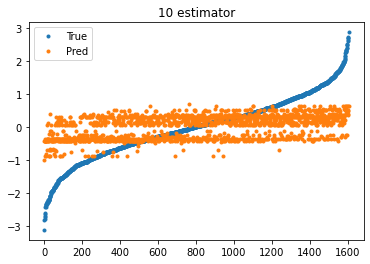

In [89]:
n_estimators = 10
regr = AdaBoostRegressor(random_state=0, n_estimators=n_estimators)
regr.fit(X, y)
print('# Model_ fitting r2:', regr.score(X, y))
print('# Pearson r2')

fig, ax = plt.subplots()
df_data = pd.DataFrame({'y_true':y, 'y_pred':regr.predict(X)})
df_data.sort_values(by='y_true', inplace=True)
ax.plot(range(len(df_data)), df_data['y_true'], label='True', ls='', marker='.')
ax.plot(range(len(df_data)), df_data['y_pred'], label='Pred', ls='', marker='.')
ax.set_title(f'{n_estimators} estimator')
ax.legend()

Model_ fitting r2: 0.2535529403668435


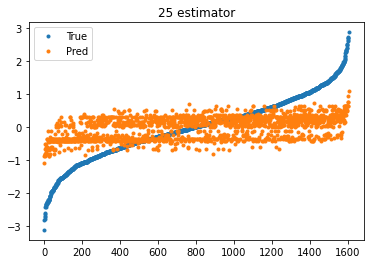

In [92]:
n_estimators = 25
regr = AdaBoostRegressor(random_state=0, n_estimators=n_estimators)
regr.fit(X, y)
print('Model_ fitting r2:', regr.score(X, y))

fig, ax = plt.subplots()
df_data = pd.DataFrame({'y_true':y, 'y_pred':regr.predict(X)})
df_data.sort_values(by='y_true', inplace=True)
ax.plot(range(len(df_data)), df_data['y_true'], label='True', ls='', marker='.')
ax.plot(range(len(df_data)), df_data['y_pred'], label='Pred', ls='', marker='.')
ax.set_title(f'{n_estimators} estimator')
ax.legend()

Model_ fitting r2: 0.2918060652470871


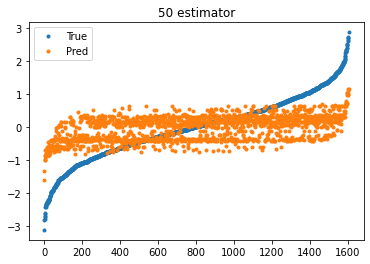

In [93]:
n_estimators = 50
regr = AdaBoostRegressor(random_state=0, n_estimators=n_estimators)
regr.fit(X, y)
print('Model_ fitting r2:', regr.score(X, y))

fig, ax = plt.subplots()
df_data = pd.DataFrame({'y_true':y, 'y_pred':regr.predict(X)})
df_data.sort_values(by='y_true', inplace=True)
ax.plot(range(len(df_data)), df_data['y_true'], label='True', ls='', marker='.')
ax.plot(range(len(df_data)), df_data['y_pred'], label='Pred', ls='', marker='.')
ax.set_title(f'{n_estimators} estimator')
ax.legend()

Model_ fitting r2: 0.32709808541769325


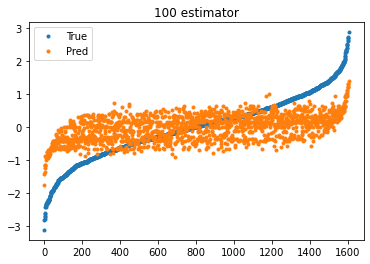

In [94]:
n_estimators = 100
regr = AdaBoostRegressor(random_state=0, n_estimators=n_estimators)
regr.fit(X, y)
print('Model_ fitting r2:', regr.score(X, y))

fig, ax = plt.subplots()
df_data = pd.DataFrame({'y_true':y, 'y_pred':regr.predict(X)})
df_data.sort_values(by='y_true', inplace=True)
ax.plot(range(len(df_data)), df_data['y_true'], label='True', ls='', marker='.')
ax.plot(range(len(df_data)), df_data['y_pred'], label='Pred', ls='', marker='.')
ax.set_title(f'{n_estimators} estimator')
ax.legend()

In [100]:
lst_pearson_r2 = []
lst_n_estimators = [10, 25, 50, 100]
for n_estimators in lst_n_estimators:
    print('# ', '#'*20, 'N estimators =', n_estimators, '#'*20)
    regr = AdaBoostRegressor(random_state=0, n_estimators=n_estimators)
    regr.fit(X, y)
    pearson_r, pearson_pval = stats.pearsonr(y, regr.predict(X))
    lst_pearson_r2.appendpend(pearson_r**2)
    print('# Model_fitting r2:', regr.score(X, y))
    print('# Pearson r2:', pearson_r**2, '; Pearson pval:', pearson_pval)

#  #################### N estimators = 10 ####################
# Model_ fitting r2: 0.21986711101476508
# Pearson r2: 0.23471378538196913 ; Pearson pval: 2.75349076901062e-95
#  #################### N estimators = 25 ####################
# Model_ fitting r2: 0.2535529403668435
# Pearson r2: 0.28280855191603727 ; Pearson pval: 6.197162553040592e-118
#  #################### N estimators = 50 ####################
# Model_ fitting r2: 0.2918060652470871
# Pearson r2: 0.32255507128855954 ; Pearson pval: 8.041683328438136e-138
#  #################### N estimators = 100 ####################
# Model_ fitting r2: 0.32709808541769325
# Pearson r2: 0.36129149382692577 ; Pearson pval: 2.358468018669879e-158


## 1.2 Apply on test set


In [103]:
snp_dir

'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_species_filter_by_pval_1e-07_maf_0.01'

In [104]:
# Load dosage
snp_dir = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_{lipid_type}_filter_by_{pval_threshold}_{maf_threshold}'
snp_fn = f'{lipid}_SNPs.{pval_threshold}.{maf_threshold}.txt'
df_dosage_all = load_dosage(snp_fn = snp_fn,
                            snp_dir = snp_dir,
                            lipid = 'CE-20:5-',
                            dosage_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/genotype_dosage/test/lipid_species',
                            dosage_fn = 'lipid_species_chr*.pval_0.001_maf_0.05.test.vcf.dosage.gz')

data_type = 'test'
trait_fn = f'lipid_{lipid_type}_ID_matched.no_dup.residual.{data_type}.txt'
df_trait, dict_trait_name_matching = load_trait_values(trait_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait',
                                                       trait_fn = trait_fn)
df_dosage_all = df_dosage_all.set_index(keys='genotype_ID').reindex(df_trait['genotype_ID']).reset_index()

# Test model
X = df_dosage_all.iloc[:, 1:].values
y = df_trait[dict_trait_name_matching[lipid]]

INFO:root:# Load filtered SNPs
INFO:root:# Get SNP dosage
INFO:root:# Get dosage from CHR11


# Process 1183/1199

INFO:root:# Number of SNPs loaded: 1183
INFO:root:# DONE


In [108]:
# Get predicted performance
pearson_r, pearson_pval = stats.pearsonr(y, regr.predict(X))
print('# Pearson r2:', pearson_r**2, '; Pearson pval:', pearson_pval)

# Pearson r2: 0.10322747302944672 ; Pearson pval: 8.113580280659784e-18


## 1.3 Test another lipid with high pearson r2

In [114]:
# Test another lipid with high pearson r2
# lipid = 'Hex3Cer-d18:1-22:0-'
lipid = 'PC-16:0_20:4-'

data_type = 'train'
lipid_type = 'species'
pval_threshold = 'pval_1e-07'
maf_threshold = 'maf_0.01'

snp_dir = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_{lipid_type}_filter_by_{pval_threshold}_{maf_threshold}'
snp_fn = f'{lipid}_SNPs.{pval_threshold}.{maf_threshold}.txt'
df_dosage_all = load_dosage(snp_fn = snp_fn,
                            snp_dir = snp_dir,
                            lipid = lipid,
                            dosage_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/genotype_dosage/train/lipid_species',
                            dosage_fn = 'lipid_species_chr*.pval_0.001_maf_0.05.vcf.dosage.gz')


trait_fn = f'lipid_{lipid_type}_ID_matched.no_dup.residual.{data_type}.txt'
df_trait, dict_trait_name_matching = load_trait_values(trait_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait',
                                                       trait_fn = trait_fn)
df_dosage_all = df_dosage_all.set_index(keys='genotype_ID').reindex(df_trait['genotype_ID']).reset_index()

# Train model
X = df_dosage_all.iloc[:, 1:].values
y = df_trait[dict_trait_name_matching[lipid]]

n_estimators = 50
regr = AdaBoostRegressor(random_state=0, n_estimators=n_estimators)
regr.fit(X, y)
print('# Model_ fitting r2:', regr.score(X, y))
print('# Pearson r2')

INFO:root:# Load filtered SNPs
INFO:root:# Get SNP dosage
INFO:root:# Get dosage from CHR11


# Process 3921/3980

INFO:root:# Number of SNPs loaded: 3921
INFO:root:# DONE
INFO:root:# Load trait values: PC-16:0_20:4-


# Model_ fitting r2: 0.3781231635278587
# Pearson r2


In [116]:
# Load dosage
snp_dir = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_{lipid_type}_filter_by_{pval_threshold}_{maf_threshold}'
snp_fn = f'{lipid}_SNPs.{pval_threshold}.{maf_threshold}.txt'
df_dosage_all = load_dosage(snp_fn = snp_fn,
                            snp_dir = snp_dir,
                            lipid = lipid,
                            dosage_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/genotype_dosage/test/lipid_species',
                            dosage_fn = 'lipid_species_chr*.pval_0.001_maf_0.05.test.vcf.dosage.gz')

data_type = 'test'
trait_fn = f'lipid_{lipid_type}_ID_matched.no_dup.residual.{data_type}.txt'
df_trait, dict_trait_name_matching = load_trait_values(trait_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait',
                                                       trait_fn = trait_fn)
df_dosage_all = df_dosage_all.set_index(keys='genotype_ID').reindex(df_trait['genotype_ID']).reset_index()

# Test model
X = df_dosage_all.iloc[:, 1:].values
y = df_trait[dict_trait_name_matching[lipid]]

# Get predicted performance
pearson_r, pearson_pval = stats.pearsonr(y, regr.predict(X))
print('# Pearson r2:', pearson_r**2, '; Pearson pval:', pearson_pval)

INFO:root:# Load filtered SNPs
INFO:root:# Get SNP dosage
INFO:root:# Get dosage from CHR11


# Process 3921/3980

INFO:root:# Number of SNPs loaded: 3921
INFO:root:# DONE
INFO:root:# Load trait values: PC-16:0_20:4-


# Pearson r2: 0.2251912045345951 ; Pearson pval: 1.5450741890833307e-39


In [122]:
df_h2.head(50).tail()

,Lipid_name,h2,se,95CI,Lipid,pearson_r2,pearson_pval,model_fitting_r2
424,CE-16:2-,0.551395,0.191033,0.374425,CE(16:2),0.000940,2.196160e-01,-0.027788
423,PC-P-17:0-20:4-_-b-,0.539768,0.182473,0.357647,PC(P-17:0/20:4) (b),0.017591,9.662530e-08,0.000928
422,PC-34:5-,0.532437,0.191718,0.375767,PC(34:5),0.013700,2.580600e-06,0.006240
421,AC-20:5-,0.530738,0.191970,0.376261,AC(20:5),0.012043,1.050935e-05,0.007069
420,CE-20:4-_[+OH],0.527121,0.183202,0.359076,CE(20:4) [+OH],0.016493,2.437478e-07,-0.011294


In [121]:
lipid = 'TG-54:3-_[SIM]'

# Test another lipid with high pearson r2
# lipid = 'Hex3Cer-d18:1-22:0-'

data_type = 'train'
lipid_type = 'species'
pval_threshold = 'pval_1e-07'
maf_threshold = 'maf_0.01'

snp_dir = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_{lipid_type}_filter_by_{pval_threshold}_{maf_threshold}'
snp_fn = f'{lipid}_SNPs.{pval_threshold}.{maf_threshold}.txt'
df_dosage_all = load_dosage(snp_fn = snp_fn,
                            snp_dir = snp_dir,
                            lipid = lipid,
                            dosage_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/genotype_dosage/train/lipid_species',
                            dosage_fn = 'lipid_species_chr*.pval_0.001_maf_0.05.vcf.dosage.gz')


trait_fn = f'lipid_{lipid_type}_ID_matched.no_dup.residual.{data_type}.txt'
df_trait, dict_trait_name_matching = load_trait_values(trait_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait',
                                                       trait_fn = trait_fn)
df_dosage_all = df_dosage_all.set_index(keys='genotype_ID').reindex(df_trait['genotype_ID']).reset_index()

# Train model
X = df_dosage_all.iloc[:, 1:].values
y = df_trait[dict_trait_name_matching[lipid]]

n_estimators = 50
regr = AdaBoostRegressor(random_state=0, n_estimators=n_estimators)
regr.fit(X, y)
print('# Model_ fitting r2:', regr.score(X, y))
print('# Pearson r2')

# Load dosage
snp_dir = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_{lipid_type}_filter_by_{pval_threshold}_{maf_threshold}'
snp_fn = f'{lipid}_SNPs.{pval_threshold}.{maf_threshold}.txt'
df_dosage_all = load_dosage(snp_fn = snp_fn,
                            snp_dir = snp_dir,
                            lipid = lipid,
                            dosage_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/genotype_dosage/test/lipid_species',
                            dosage_fn = 'lipid_species_chr*.pval_0.001_maf_0.05.test.vcf.dosage.gz')

data_type = 'test'
trait_fn = f'lipid_{lipid_type}_ID_matched.no_dup.residual.{data_type}.txt'
df_trait, dict_trait_name_matching = load_trait_values(trait_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait',
                                                       trait_fn = trait_fn)
df_dosage_all = df_dosage_all.set_index(keys='genotype_ID').reindex(df_trait['genotype_ID']).reset_index()

# Test model
X = df_dosage_all.iloc[:, 1:].values
y = df_trait[dict_trait_name_matching[lipid]]

# Get predicted performance
pearson_r, pearson_pval = stats.pearsonr(y, regr.predict(X))
print('# Pearson r2:', pearson_r**2, '; Pearson pval:', pearson_pval)

INFO:root:# Load filtered SNPs
INFO:root:# Get SNP dosage
INFO:root:# Get dosage from CHR11


# Process 7/7

INFO:root:# Number of SNPs loaded: 7
INFO:root:# DONE
INFO:root:# Load trait values: TG-54:3-_[SIM]
INFO:root:# Load filtered SNPs
INFO:root:# Get SNP dosage
INFO:root:# Get dosage from CHR11


# Model_ fitting r2: 0.04670831793959651
# Pearson r2
# Process 7/7

INFO:root:# Number of SNPs loaded: 7
INFO:root:# DONE
INFO:root:# Load trait values: TG-54:3-_[SIM]


# Pearson r2: 0.03449598264409439 ; Pearson pval: 1.0584299608721402e-06


In [124]:
lipid = 'AC-20:5-'

# Test another lipid with high pearson r2
# lipid = 'Hex3Cer-d18:1-22:0-'

data_type = 'train'
lipid_type = 'species'
pval_threshold = 'pval_1e-07'
maf_threshold = 'maf_0.01'

snp_dir = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_{lipid_type}_filter_by_{pval_threshold}_{maf_threshold}'
snp_fn = f'{lipid}_SNPs.{pval_threshold}.{maf_threshold}.txt'
df_dosage_all = load_dosage(snp_fn = snp_fn,
                            snp_dir = snp_dir,
                            lipid = lipid,
                            dosage_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/genotype_dosage/train/lipid_species',
                            dosage_fn = 'lipid_species_chr*.pval_0.001_maf_0.05.vcf.dosage.gz')


trait_fn = f'lipid_{lipid_type}_ID_matched.no_dup.residual.{data_type}.txt'
df_trait, dict_trait_name_matching = load_trait_values(trait_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait',
                                                       trait_fn = trait_fn)
df_dosage_all = df_dosage_all.set_index(keys='genotype_ID').reindex(df_trait['genotype_ID']).reset_index()

# Train model
X = df_dosage_all.iloc[:, 1:].values
y = df_trait[dict_trait_name_matching[lipid]]

n_estimators = 50
regr = AdaBoostRegressor(random_state=0, n_estimators=n_estimators)
regr.fit(X, y)
print('# Model_ fitting r2:', regr.score(X, y))
print('# Pearson r2', stats.pearsonr(y, regr.predict(X))[0]**2)

# Load dosage
snp_dir = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_{lipid_type}_filter_by_{pval_threshold}_{maf_threshold}'
snp_fn = f'{lipid}_SNPs.{pval_threshold}.{maf_threshold}.txt'
df_dosage_all = load_dosage(snp_fn = snp_fn,
                            snp_dir = snp_dir,
                            lipid = lipid,
                            dosage_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/genotype_dosage/test/lipid_species',
                            dosage_fn = 'lipid_species_chr*.pval_0.001_maf_0.05.test.vcf.dosage.gz')

data_type = 'test'
trait_fn = f'lipid_{lipid_type}_ID_matched.no_dup.residual.{data_type}.txt'
df_trait, dict_trait_name_matching = load_trait_values(trait_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait',
                                                       trait_fn = trait_fn)
df_dosage_all = df_dosage_all.set_index(keys='genotype_ID').reindex(df_trait['genotype_ID']).reset_index()

# Test model
X = df_dosage_all.iloc[:, 1:].values
y = df_trait[dict_trait_name_matching[lipid]]

# Get predicted performance
pearson_r, pearson_pval = stats.pearsonr(y, regr.predict(X))
print('# Pearson r2:', pearson_r**2, '; Pearson pval:', pearson_pval)

INFO:root:# Load filtered SNPs
INFO:root:# Get SNP dosage
INFO:root:# Get dosage from CHR11


# Process 82/82

INFO:root:# Number of SNPs loaded: 82
INFO:root:# DONE
INFO:root:# Load trait values: AC-20:5-
INFO:root:# Load filtered SNPs
INFO:root:# Get SNP dosage
INFO:root:# Get dosage from CHR11


# Model_ fitting r2: 0.07818065614003467
# Pearson r2 0.0881129551759923
# Process 82/82

INFO:root:# Number of SNPs loaded: 82
INFO:root:# DONE
INFO:root:# Load trait values: AC-20:5-


# Pearson r2: 0.044617955798424834 ; Pearson pval: 2.6211116808340287e-08


# 2. Use cross validation and grid search to tune parameters

## 2.0 Load train and test data

In [32]:
from sklearn.experimental import enable_halving_search_cv # Required for HalvingGridSearch
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV
import sys
sys.path.insert(0, '/data100t1/home/wanying/CCHC/lipidomics/code/utils') # Search util first

# Import functions from my module
import load_dosage
import load_trait_values
import set_logging
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.metrics import r2_score

In [60]:
# Load training data
data_type = 'train'
lipid_type = 'species'
pval_threshold = 'pval_1e-07'
maf_threshold = 'maf_0.01'
# lipid = 'CE-20:5-' # PA-36:3-
# lipid = 'PA-36:3-' 
lipid = 'FA-20:4-'

print('#', '#'*30, ' Load training data', '#'*30)
print('#', '#' * 30, 'Load dosage', '#' * 30)
set_logging.set_logging('test_run.log')

dosage_dir = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/genotype_dosage/{data_type}/lipid_species'
dosage_fn = 'lipid_species_chr*.pval_0.001_maf_0.05.vcf.dosage.gz'

snp_dir = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_{lipid_type}_filter_by_{pval_threshold}_{maf_threshold}'
snp_fn = f'{lipid}_SNPs.{pval_threshold}.{maf_threshold}.txt'

df_dosage = load_dosage.load_dosage(snp_dir, snp_fn,
                                    dosage_dir = dosage_dir,
                                    dosage_fn = dosage_fn)

print('\n#', '#' * 30, 'Load lipid trait', '#' * 30)
# Load lipid trait
trait_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait'
trait_fn = f'lipid_{lipid_type}_ID_matched.no_dup.residual.{data_type}.txt'
fn_trait_name_matching = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait/lipid_{lipid_type}.list'
df_lipid_trait, dict_lipid_name_matching = load_trait_values.load_trait_values(trait_dir,
                                                                               trait_fn,
                                                                               fn_trait_name_matching)

print('\n#', '#' * 30, 'Reorder samples', '#' * 30)
print('# - Reorder samples, remove sample with missing value')
# Reorder dosage and trait dataframes
# Take the shorter one between dosage and lipid measure to avoid missing values
if len(df_dosage) < len(df_lipid_trait):
    df_lipid_trait = df_lipid_trait.set_index(keys='genotype_ID').reindex(df_dosage['genotype_ID']).reset_index()
else:
    df_dosage = df_dosage.set_index(keys='genotype_ID').reindex(df_lipid_trait['genotype_ID']).reset_index()
print('# - Shape of lipid trait, dosage:', df_lipid_trait.shape, df_dosage.shape)
display(df_lipid_trait.head(2))
display(df_dosage.head(2))

# Create X, y for model training
X = df_dosage.iloc[:, 1:].values
y = df_lipid_trait[dict_lipid_name_matching[lipid]]
y_all = df_lipid_trait.copy()
print('# - Shape of X, y:', X.shape, y.shape)

INFO:root:# Load filtered SNPs based on GWAS pvalues
INFO:root:# Get SNP dosage
INFO:root:# - PASS
INFO:root:# Get dosage from CHR2


# ##############################  Load training data ##############################
# ############################## Load dosage ##############################
# Process 1/216

INFO:root:# Get dosage from CHR11


# Process 214/216

INFO:root:# Number of SNPs loaded: 214
INFO:root:# Number of SNPs not_found: 2
INFO:root:# Number of multiallelic SNPs ignored: 0
INFO:root:# DONE
INFO:root:# Load trait values



# ############################## Load lipid trait ##############################

# ############################## Reorder samples ##############################
# - Reorder samples, remove sample with missing value
# - Shape of lipid trait, dosage: (1606, 833) (1606, 215)


,RRID,genotype_ID,LABID,Sph(d18:1),Sph(d18:2),S1P(d16:1),S1P(d18:0),S1P(d18:1),S1P(d18:2),dhCer(d18:0/16:0),...,TG(O-54:4) [NL-18:2],Ubiquinone,CE(18:2) [+OH],CE(20:4) [+OH],LPC(18:2) [+OH],LPC(20:4) [+OH],LPC(22:6) [+OH],PC(34:2) [+OH],PC(36:4) [+OH],PC(38:6) [+OH]
0,BD0009,BD0009_BD4009,10Y0308,0.275791,0.549473,0.721941,1.557758,1.322990,0.270136,1.181562,...,-0.065122,0.033647,1.205709,0.897438,0.353739,0.117593,-0.357713,0.627687,-0.706694,-0.918218
1,BD0058,BD0058_BD4058,10Y0246,2.874146,2.689427,0.118917,1.633277,1.847306,1.474152,0.553985,...,-0.411708,0.301072,1.222128,1.754571,1.206090,1.780087,1.669920,-0.772111,1.120944,0.108486


,genotype_ID,chr2:76849764:A:G,chr11:60045010:A:AACAG,chr11:60045028:T:C,chr11:60045141:A:ATTTC,chr11:60046444:TA:T,chr11:60046700:G:A,chr11:60046814:A:G,chr11:60047666:C:T,chr11:60052854:G:A,...,chr11:61905173:G:C,chr11:61944659:T:C,chr11:61944770:C:T,chr11:61971670:G:C,chr11:62023889:GA:G,chr11:62023946:T:C,chr11:62024547:C:T,chr11:62897014:C:T,chr11:64824500:T:C,chr11:64847178:G:GA
0,BD0009_BD4009,0,0,0,0,0,0,0,0,0,...,1,2,2,1,1,0,1,1.991,0.97,0.984
1,BD0058_BD4058,1,0,0,0,0,0,0,0,0,...,1,2,2,1,0,1,0,0,1,1


# - Shape of X, y: (1606, 214) (1606,)


In [61]:
# Load test data
data_type = 'test'
lipid_type = 'species'
pval_threshold = 'pval_1e-07'
maf_threshold = 'maf_0.01'

print('#', '#'*30, ' Load test data', '#'*30)
print('#', '#' * 30, 'Load dosage', '#' * 30)
set_logging.set_logging('test_run.log')

dosage_dir = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/genotype_dosage/{data_type}/lipid_species'
dosage_fn = 'lipid_species_chr*.pval_0.001_maf_0.05.test.vcf.dosage.gz'

snp_dir = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/outputs/fastGWA/lipid_{lipid_type}_filter_by_{pval_threshold}_{maf_threshold}'
snp_fn = f'{lipid}_SNPs.{pval_threshold}.{maf_threshold}.txt'

df_dosage = load_dosage.load_dosage(snp_dir, snp_fn,
                                    dosage_dir = dosage_dir,
                                    dosage_fn = dosage_fn)

print('\n#', '#' * 30, 'Load lipid trait', '#' * 30)
# Load lipid trait
trait_dir = '/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait'
trait_fn = f'lipid_{lipid_type}_ID_matched.no_dup.residual.{data_type}.txt'
fn_trait_name_matching = f'/data100t1/home/wanying/CCHC/lipidomics/20231211_rerun/inputs/lipid_trait/lipid_{lipid_type}.list'
df_lipid_trait, dict_lipid_name_matching = load_trait_values.load_trait_values(trait_dir,
                                                                               trait_fn,
                                                                               fn_trait_name_matching)

print('\n#', '#' * 30, 'Reorder samples', '#' * 30)
print('# - Reorder samples, remove sample with missing value')
# Reorder dosage and trait dataframes
# Take the shorter one between dosage and lipid measure to avoid missing values
if len(df_dosage) < len(df_lipid_trait):
    df_lipid_trait = df_lipid_trait.set_index(keys='genotype_ID').reindex(df_dosage['genotype_ID']).reset_index()
else:
    df_dosage = df_dosage.set_index(keys='genotype_ID').reindex(df_lipid_trait['genotype_ID']).reset_index()
print('# - Shape of lipid trait, dosage:', df_lipid_trait.shape, df_dosage.shape)
display(df_lipid_trait.head(2))
display(df_dosage.head(2))

# Create X, y for model training
X_test = df_dosage.iloc[:, 1:].values
y_test = df_lipid_trait[dict_lipid_name_matching[lipid]]
y_all_test = df_lipid_trait.copy()
print('# - Shape of X_test, y_test:', X_test.shape, y_test.shape)

INFO:root:# Load filtered SNPs based on GWAS pvalues
INFO:root:# Get SNP dosage
INFO:root:# - PASS
INFO:root:# Get dosage from CHR2


# ##############################  Load test data ##############################
# ############################## Load dosage ##############################
# Process 1/216

INFO:root:# Get dosage from CHR11


# Process 214/216

INFO:root:# Number of SNPs loaded: 214
INFO:root:# Number of SNPs not_found: 2
INFO:root:# Number of multiallelic SNPs ignored: 0
INFO:root:# DONE
INFO:root:# Load trait values



# ############################## Load lipid trait ##############################

# ############################## Reorder samples ##############################
# - Reorder samples, remove sample with missing value
# - Shape of lipid trait, dosage: (681, 833) (681, 215)


,RRID,genotype_ID,LABID,Sph(d18:1),Sph(d18:2),S1P(d16:1),S1P(d18:0),S1P(d18:1),S1P(d18:2),dhCer(d18:0/16:0),...,TG(O-54:4) [NL-18:2],Ubiquinone,CE(18:2) [+OH],CE(20:4) [+OH],LPC(18:2) [+OH],LPC(20:4) [+OH],LPC(22:6) [+OH],PC(34:2) [+OH],PC(36:4) [+OH],PC(38:6) [+OH]
0,BD0010,BD0010_BD4010,10Y0021,0.229686,0.996114,1.032505,0.261368,1.290543,1.485298,0.587218,...,0.533136,1.166953,0.124958,1.067570,1.277118,1.135830,0.895316,0.781975,1.030432,0.476622
1,BD0382,BD0382_BD4382,10Y0381,0.599855,0.220383,-0.410949,1.318587,1.176857,0.823059,-0.953008,...,-0.987629,-0.165116,-0.966227,0.453366,0.127089,-0.045657,-0.168233,0.381594,-0.810531,-0.826416


,genotype_ID,chr2:76849764:A:G,chr11:60045010:A:AACAG,chr11:60045028:T:C,chr11:60045141:A:ATTTC,chr11:60046444:TA:T,chr11:60046700:G:A,chr11:60046814:A:G,chr11:60047666:C:T,chr11:60052854:G:A,...,chr11:61905173:G:C,chr11:61944659:T:C,chr11:61944770:C:T,chr11:61971670:G:C,chr11:62023889:GA:G,chr11:62023946:T:C,chr11:62024547:C:T,chr11:62897014:C:T,chr11:64824500:T:C,chr11:64847178:G:GA
0,BD0010_BD4010,0,1.999,1.999,1.999,1.999,1.999,1.999,1.999,1.999,...,0,0,0,0,1.999,0,1.999,1.999,0,0
1,BD0382_BD4382,0,0,0,0,0,0,0,0,0,...,1,1,1,1,2,0,2,0,0.97,0.972


# - Shape of X_test, y_test: (681, 214) (681,)


## 2.1 Test run of AdaBoost


# #################### Test run of FA-20:4- ####################
# - Estimator: DT regressor
# HalvingGridSearchCV
Best params: {'learning_rate': 0.08, 'n_estimators': 50}
Best_score (mean): -0.09766391974696821
r2 on train: 0.12583229192083645
r2 on test: 0.018083113624323688
Pearson r2 on test: 0.030885960392342822

# GridSearchCV
Best params: {'learning_rate': 0.02, 'n_estimators': 50}
Best_score (mean): -0.09003409013241083
r2 on train: 0.12042615175863902
r2 on test: 0.01763057516292943
Pearson r2 on test: 0.03025145330384189


Text(0.5, 0.98, 'AdaBoost (DT regressor)')

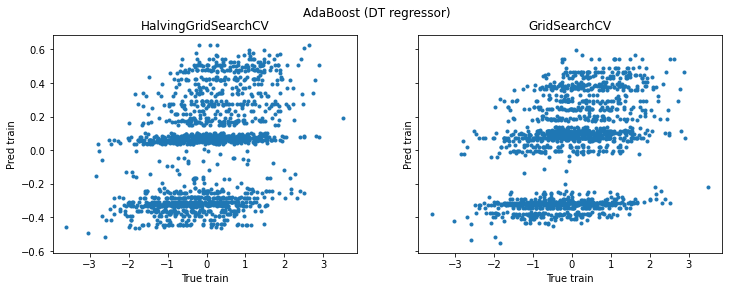

In [20]:
print('\n#', '#' * 20, f'Test run of {lipid}', '#' * 20)
print('# - Estimator: DT regressor')
regr = AdaBoostRegressor(random_state=0)

# param_grid = {'n_estimators':[20, 50, 100, 200],
#               'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

# param_grid = {'n_estimators':[20, 50, 100, 200, 500],
#               'learning_rate':[0.5, 1]}
param_grid = {'n_estimators':[20, 50, 100, 200],
              'learning_rate':[0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

print('# HalvingGridSearchCV')
search = HalvingGridSearchCV(estimator=regr, param_grid=param_grid, cv=10, n_jobs=8, random_state=1).fit(X, y)
print('Best params:', search.best_params_)
print('Best_score (mean):', search.best_score_)
print('r2 on train:', search.score(X, y))
print('r2 on test:', r2_score(y_test, search.predict(X_test)))
print('Pearson r2 on test:', stats.pearsonr(y_test, search.predict(X_test))[0]**2)

df_halving = pd.DataFrame(search.cv_results_)

ax[0].plot(y.values, search.predict(X), ls='', marker='.')
ax[0].set_xlabel('True train')
ax[0].set_ylabel('Pred train')
ax[0].set_title('HalvingGridSearchCV')

print('\n# GridSearchCV')
search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=10, n_jobs=8).fit(X, y)
print('Best params:', search.best_params_)
print('Best_score (mean):', search.best_score_)
print('r2 on train:', search.score(X, y))
print('r2 on test:', r2_score(y_test, search.predict(X_test)))
print('Pearson r2 on test:', stats.pearsonr(y_test, search.predict(X_test))[0]**2)

df_gridsearch = pd.DataFrame(search.cv_results_)

ax[1].plot(y.values, search.predict(X), ls='', marker='.')
ax[1].set_xlabel('True train')
ax[1].set_ylabel('Pred train')
ax[1].set_title('GridSearchCV')
fig.suptitle('AdaBoost (DT regressor)')

# - Estimator: OLS linear regressor
# HalvingGridSearchCV
Best params: {'learning_rate': 1, 'n_estimators': 200}
Best_score (mean): -1.0325810424605817
r2 on train: 0.3236241567860193
r2 on test: -0.4575284125632617
Pearson r2 on test: 0.00828025867950976

# GridSearchCV
Best params: {'learning_rate': 1, 'n_estimators': 200}
Best_score (mean): -1.0289028674858753
r2 on train: 0.3236241567860193
r2 on test: -0.4575284125632617
Pearson r2 on test: 0.00828025867950976


Text(0.5, 0.98, 'AdaBoost (OLS linear regressor)')

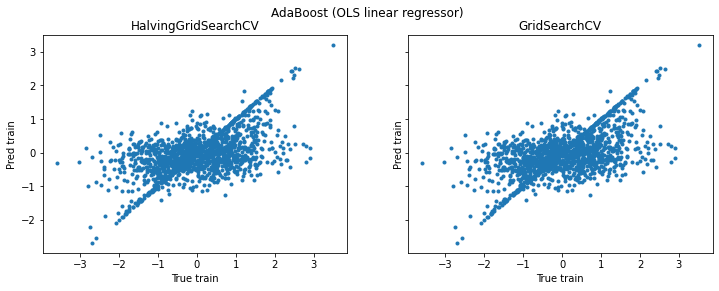

In [21]:
print('# - Estimator: OLS linear regressor')
base_estimator = LinearRegression()

regr = AdaBoostRegressor(random_state=0, estimator=base_estimator)

# param_grid = {'n_estimators':[20, 50, 100, 200],
#               'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
param_grid = {'n_estimators':[20, 50, 100, 200],
              'learning_rate':[0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

print('# HalvingGridSearchCV')
search = HalvingGridSearchCV(estimator=regr, param_grid=param_grid, cv=10, n_jobs=8, random_state=1).fit(X, y)
print('Best params:', search.best_params_)
print('Best_score (mean):', search.best_score_)
print('r2 on train:', search.score(X, y))
print('r2 on test:', r2_score(y_test, search.predict(X_test)))
print('Pearson r2 on test:', stats.pearsonr(y_test, search.predict(X_test))[0]**2)

df_halving = pd.DataFrame(search.cv_results_)

ax[0].plot(y.values, search.predict(X), ls='', marker='.')
ax[0].set_xlabel('True train')
ax[0].set_ylabel('Pred train')
ax[0].set_title('HalvingGridSearchCV')

print('\n# GridSearchCV')
search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=10, n_jobs=8).fit(X, y)
print('Best params:', search.best_params_)
print('Best_score (mean):', search.best_score_)
print('r2 on train:', search.score(X, y))
print('r2 on test:', r2_score(y_test, search.predict(X_test)))
print('Pearson r2 on test:', stats.pearsonr(y_test, search.predict(X_test))[0]**2)

df_gridsearch = pd.DataFrame(search.cv_results_)

ax[1].plot(y.values, search.predict(X), ls='', marker='.')
ax[1].set_xlabel('True train')
ax[1].set_ylabel('Pred train')
ax[1].set_title('GridSearchCV')
fig.suptitle('AdaBoost (OLS linear regressor)')

# - Estimator: elastic net
# HalvingGridSearchCV
Best params: {'learning_rate': 0.4, 'n_estimators': 200}
Best_score (mean): -0.16860888363372567
r2 on train: 0.0027939379326628044
r2 on test: 0.0018083342468491193
Pearson r2 on test: 0.02930114880134764

# GridSearchCV
Best params: {'learning_rate': 0.7, 'n_estimators': 50}
Best_score (mean): -0.15624875512882264
r2 on train: 0.00026626442790056437
r2 on test: 0.00014706129675012836
Pearson r2 on test: 0.015405457276741554


Text(0.5, 0.98, 'AdaBoost (elastic net)')

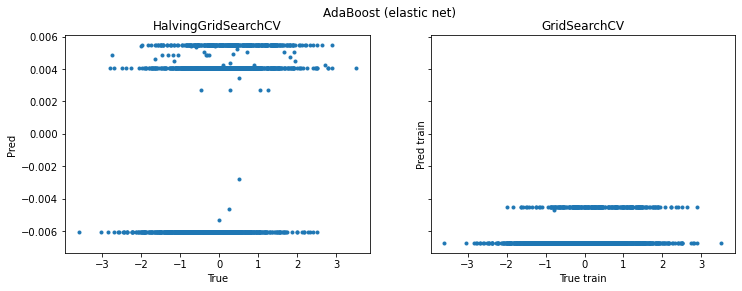

In [22]:
print('# - Estimator: elastic net')
base_estimator = ElasticNet()

regr = AdaBoostRegressor(random_state=0, estimator=base_estimator)

# param_grid = {'n_estimators':[20, 50, 100, 200],
#               'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
param_grid = {'n_estimators':[20, 50, 100, 200],
              'learning_rate':[0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

print('# HalvingGridSearchCV')
search = HalvingGridSearchCV(estimator=regr, param_grid=param_grid, cv=10, n_jobs=8, random_state=1).fit(X, y)
print('Best params:', search.best_params_)
print('Best_score (mean):', search.best_score_)
print('r2 on train:', search.score(X, y))
print('r2 on test:', r2_score(y_test, search.predict(X_test)))
print('Pearson r2 on test:', stats.pearsonr(y_test, search.predict(X_test))[0]**2)

df_halving = pd.DataFrame(search.cv_results_)

ax[0].plot(y.values, search.predict(X), ls='', marker='.')
ax[0].set_xlabel('True')
ax[0].set_ylabel('Pred')
ax[0].set_title('HalvingGridSearchCV')

print('\n# GridSearchCV')
search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=10, n_jobs=8).fit(X, y)
print('Best params:', search.best_params_)
print('Best_score (mean):', search.best_score_)
print('r2 on train:', search.score(X, y))
print('r2 on test:', r2_score(y_test, search.predict(X_test)))
print('Pearson r2 on test:', stats.pearsonr(y_test, search.predict(X_test))[0]**2)

df_gridsearch = pd.DataFrame(search.cv_results_)

ax[1].plot(y.values, search.predict(X), ls='', marker='.')
ax[1].set_xlabel('True train')
ax[1].set_ylabel('Pred train')
ax[1].set_title('GridSearchCV')
fig.suptitle('AdaBoost (elastic net)')

# - Estimator: lasso
# HalvingGridSearchCV
Best params: {'learning_rate': 0.4, 'n_estimators': 20}
Best_score (mean): -0.17012566984830668
r2 on train: -3.0457753784851604e-05
r2 on test: -3.1018656850623216e-05


/data100t1/gapps/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Pearson r2 on test: nan

# GridSearchCV
Best params: {'learning_rate': 0.7, 'n_estimators': 20}
Best_score (mean): -0.15545430663236098
r2 on train: -4.6186604066189574e-05
r2 on test: -4.7037166061025815e-05


/data100t1/gapps/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Pearson r2 on test: nan


Text(0.5, 0.98, 'AdaBoost (lasso)')

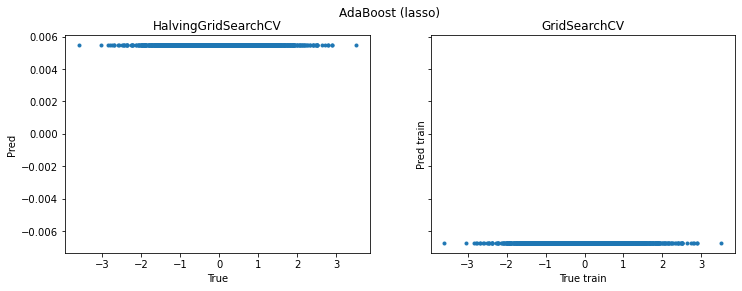

In [23]:
print('# - Estimator: lasso')
base_estimator = Lasso()

regr = AdaBoostRegressor(random_state=0, estimator=base_estimator)

param_grid = {'n_estimators':[20, 50, 100, 200],
              'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

print('# HalvingGridSearchCV')
search = HalvingGridSearchCV(estimator=regr, param_grid=param_grid, cv=10, n_jobs=8, random_state=1).fit(X, y)
print('Best params:', search.best_params_)
print('Best_score (mean):', search.best_score_)
print('r2 on train:', search.score(X, y))
print('r2 on test:', r2_score(y_test, search.predict(X_test)))
print('Pearson r2 on test:', stats.pearsonr(y_test, search.predict(X_test))[0]**2)

df_halving = pd.DataFrame(search.cv_results_)

ax[0].plot(y.values, search.predict(X), ls='', marker='.')
ax[0].set_xlabel('True')
ax[0].set_ylabel('Pred')
ax[0].set_title('HalvingGridSearchCV')

print('\n# GridSearchCV')
search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=10, n_jobs=8).fit(X, y)
print('Best params:', search.best_params_)
print('Best_score (mean):', search.best_score_)
print('r2 on train:', search.score(X, y))
print('r2 on test:', r2_score(y_test, search.predict(X_test)))
print('Pearson r2 on test:', stats.pearsonr(y_test, search.predict(X_test))[0]**2)

df_gridsearch = pd.DataFrame(search.cv_results_)

ax[1].plot(y.values, search.predict(X), ls='', marker='.')
ax[1].set_xlabel('True train')
ax[1].set_ylabel('Pred train')
ax[1].set_title('GridSearchCV')
fig.suptitle('AdaBoost (lasso)')

## 2.2 Test run of gradient boosting
Gradient boosting function does not accept other base estimtors.
It uses decision tree regressor, which might be the best option in many cases


# ########## Test run of FA-20:4- using gradient boosting ##########
# - Estimator: DT regressor
# HalvingGridSearchCV
Best params: {'learning_rate': 0.02, 'n_estimators': 50}
Best_score (mean): -0.10468294962162457
r2 on train: 0.1251642186159443
r2 on test: 0.021921544943741877
Pearson r2 on test: 0.023868451348793243

# GridSearchCV
Best params: {'learning_rate': 0.06, 'n_estimators': 20}
Best_score (mean): -0.10111831083405734
r2 on train: 0.13891805772743004
r2 on test: 0.015739194853604643
Pearson r2 on test: 0.021528783553904942


Text(0.5, 0.98, 'Gradient boosting')

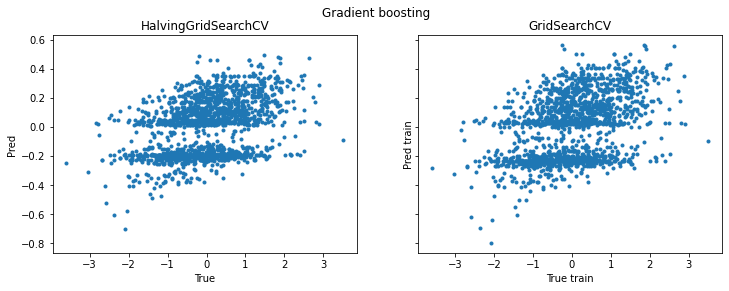

In [24]:
print('\n#', '#' * 10, f'Test run of {lipid} using gradient boosting', '#' * 10)
print('# - Estimator: DT regressor')
regr = GradientBoostingRegressor(random_state=0)

# param_grid = {'n_estimators':[20, 50, 100, 200],
#               'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
param_grid = {'n_estimators':[10, 20, 50, 100, 200],
              'learning_rate':[0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

print('# HalvingGridSearchCV')
search = HalvingGridSearchCV(estimator=regr, param_grid=param_grid, cv=10, n_jobs=8, random_state=1).fit(X, y)
print('Best params:', search.best_params_)
print('Best_score (mean):', search.best_score_)
print('r2 on train:', search.score(X, y))
print('r2 on test:', r2_score(y_test, search.predict(X_test)))
print('Pearson r2 on test:', stats.pearsonr(y_test, search.predict(X_test))[0]**2)

df_halving = pd.DataFrame(search.cv_results_)

ax[0].plot(y.values, search.predict(X), ls='', marker='.')
ax[0].set_xlabel('True')
ax[0].set_ylabel('Pred')
ax[0].set_title('HalvingGridSearchCV')

print('\n# GridSearchCV')
search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=10, n_jobs=8).fit(X, y)
print('Best params:', search.best_params_)
print('Best_score (mean):', search.best_score_)
print('r2 on train:', search.score(X, y))
print('r2 on test:', r2_score(y_test, search.predict(X_test)))
print('Pearson r2 on test:', stats.pearsonr(y_test, search.predict(X_test))[0]**2)

df_gridsearch = pd.DataFrame(search.cv_results_)

ax[1].plot(y.values, search.predict(X), ls='', marker='.')
ax[1].set_xlabel('True train')
ax[1].set_ylabel('Pred train')
ax[1].set_title('GridSearchCV')
fig.suptitle('Gradient boosting')


# ########## Test run of FA-20:4- using gradient boosting ##########
# - Estimator: DT regressor
# HalvingGridSearchCV
Best params: {'learning_rate': 0.1, 'n_estimators': 20}
Best_score (mean): -0.10907465986798356
r2 on train: 0.18235437820751832
r2 on test: 0.004919726320180895
Pearson r2 on test: 0.02122042595651904

# GridSearchCV
Best params: {'learning_rate': 0.1, 'n_estimators': 20}
Best_score (mean): -0.10752370943074485
r2 on train: 0.18235437820751832
r2 on test: 0.004919726320180895
Pearson r2 on test: 0.02122042595651904


Text(0.5, 1.0, 'GridSearchCV')

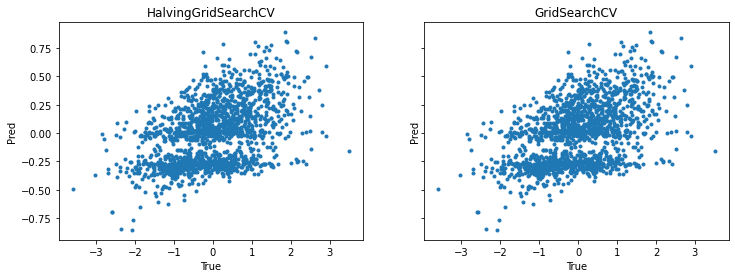

In [25]:
print('\n#', '#' * 10, f'Test run of {lipid} using gradient boosting', '#' * 10)
print('# - Estimator: DT regressor')
regr = GradientBoostingRegressor(random_state=0)

param_grid = {'n_estimators':[20, 50, 100, 200, 500],
              'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
# param_grid = {'n_estimators':[20, 50, 100, 200],
#               'learning_rate':[0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

print('# HalvingGridSearchCV')
search = HalvingGridSearchCV(estimator=regr, param_grid=param_grid, cv=10, n_jobs=8, random_state=1).fit(X, y)
print('Best params:', search.best_params_)
print('Best_score (mean):', search.best_score_)
print('r2 on train:', search.score(X, y))
print('r2 on test:', r2_score(y_test, search.predict(X_test)))
print('Pearson r2 on test:', stats.pearsonr(y_test, search.predict(X_test))[0]**2)

df_halving = pd.DataFrame(search.cv_results_)

ax[0].plot(y.values, search.predict(X), ls='', marker='.')
ax[0].set_xlabel('True')
ax[0].set_ylabel('Pred')
ax[0].set_title('HalvingGridSearchCV')

print('\n# GridSearchCV')
search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=10, n_jobs=8).fit(X, y)
print('Best params:', search.best_params_)
print('Best_score (mean):', search.best_score_)
print('r2 on train:', search.score(X, y))
print('r2 on test:', r2_score(y_test, search.predict(X_test)))
print('Pearson r2 on test:', stats.pearsonr(y_test, search.predict(X_test))[0]**2)

df_gridsearch = pd.DataFrame(search.cv_results_)

ax[1].plot(y.values, search.predict(X), ls='', marker='.')
ax[1].set_xlabel('True')
ax[1].set_ylabel('Pred')
ax[1].set_title('GridSearchCV')


# 3. Test multilayer perceptron (MLP)

In [23]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [24]:
# # Example code
# X, y = make_regression(n_samples=200, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     random_state=1)
# regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
# regr.predict(X_test[:2])
# regr.score(X_test, y_test)

/data100t1/home/wanying/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.4162338898076594

In [57]:
# hidden_layer_sizes = (100,100)
hidden_layer_sizes = (100)
regr = MLPRegressor(random_state=1,
                    max_iter=500,
                    hidden_layer_sizes=hidden_layer_sizes).fit(X, y)
print('# 1 hiddden layer')
print('r2 on train:', regr.score(X, y))
print('r2 on test:', regr.score(X_test, y_test))
print('person r2 on test:', stats.pearsonr(y_test, regr.predict(X_test))[0]**2)

# 1 hiddden layer
r2 on train: 0.12549648692726034
r2 on test: -0.0941417061170502
person r2 on test: 0.010960549364309057


In [56]:
# hidden_layer_sizes = (100,100)
hidden_layer_sizes = (100, 100)
regr = MLPRegressor(random_state=1,
                    max_iter=500,
                    hidden_layer_sizes=hidden_layer_sizes).fit(X, y)
print('# 2 hiddden layers')
print('r2 on train:', regr.score(X, y))
print('r2 on test:', regr.score(X_test, y_test))
print('person r2 on test:', stats.pearsonr(y_test, regr.predict(X_test))[0]**2)

# 2 hiddden layers
r2 on train: 0.43849330646390294
r2 on test: -0.22474797847186134
person r2 on test: 0.0177330536604478


In [55]:
# hidden_layer_sizes = (100,100)
hidden_layer_sizes = (100, 100)
regr = MLPRegressor(random_state=1,
                    max_iter=10000,
                    hidden_layer_sizes=hidden_layer_sizes).fit(X, y)
print('# 2 hiddden layers, more iteration')
print('r2 on train:', regr.score(X, y))
print('r2 on test:', regr.score(X_test, y_test))
print('person r2 on test:', stats.pearsonr(y_test, regr.predict(X_test))[0]**2)

# 2 hiddden layers, more iteration
r2 on train: 0.43849330646390294
r2 on test: -0.22474797847186134
person r2 on test: 0.0177330536604478


In [72]:

# hidden_layer_sizes = (100,100)
hidden_layer_sizes = (100)
regr = MLPRegressor(random_state=1,
                    max_iter=500,
                    hidden_layer_sizes=hidden_layer_sizes).fit(X, y_all.iloc[:, 3:].values)
print('# 1 hiddden layer, with all 830 lipid species as output')
print('r2 on train:', regr.score(X, y_all.iloc[:, 3:].values))
print('r2 on test:', regr.score(X_test, y_all_test.iloc[:, 3:].values))
# print('person r2 on test:', stats.pearsonr(y_all_test.iloc[:, 3:].values, regr.predict(X_test))[0]**2)

# 1 hiddden layer, with all 830 lipid species as output
r2 on train: 0.17978869204178208
r2 on test: -0.06190614261898067


In [ ]:
hidden_layer_sizes = (100,100)
# hidden_layer_sizes = (100)
regr = MLPRegressor(random_state=1,
                    max_iter=1000,
                    hidden_layer_sizes=hidden_layer_sizes).fit(X, y_all.iloc[:, 3:].values)
print('# 1 hiddden layer, with all 830 lipid species as output')
print('r2 on train:', regr.score(X, y_all.iloc[:, 3:].values))
print('r2 on test:', regr.score(X_test, y_all_test.iloc[:, 3:].values))
# print('person r2 on test:', stats.pearsonr(y_all_test.iloc[:, 3:].values, regr.predict(X_test))[0]**2)

# 1 hiddden layer, with all 830 lipid species as output
r2 on train: 0.32731176400441153
r2 on test: -0.212778978349677


In [2]:
10.0 ** -np.arange(1, 7)

array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])

In [ ]:
np.arange(1, 7)